# HR Analytics: Promotion Prediction
**Goal:** Help HR identify employees likely to be promoted by analyzing historical data and training interpretable + high-performing models.  

---

## Introduction & Problem Statement
Every year, HR managers are faced with a **critical decision** — deciding which employees should be promoted.  
Promotions are **not just a reward**; they are an investment in future leadership, motivation, and retention.  

However, manual decision-making often struggles to balance:
- **Performance metrics**
- **Experience and tenure**
- **Training efforts**
- **Fairness and bias reduction**

**Our mission** is to use **data-driven methods** to help HR identify employees most likely to deserve a promotion — fairly, transparently, and accurately.

---

## Objectives
- Build a robust model to predict promotions (`is_promoted`).
- Quantify what drives promotions (feature importance & diagnostics).
- Deliver a repeatable workflow (EDA → Preprocess → FE → Train → Predict).
- Save models and predictions for downstream use.

---

## Dataset (HR Analytics)
- **Train**: `data/train.csv` — includes `is_promoted`.
- **Test**: `data/test.csv` — same schema **without** `is_promoted`.
- Key columns: `employee_id`,`department`, `region`, `education`, `gender`, `recruitment_channel`, `no_of_trainings`, `age`, `previous_year_rating`, `length_of_service`, `KPIs_met >80%`, `awards_won?`, `avg_training_score`, plus engineered features like `age_bucket`, `tenure_bucket`, `high_performance_flag`.

---

## Business Questions We’ll Answer
- Which factors (performance, tenure, training, etc.) matter most for promotions?
- How well can we predict promotions on unseen data?
- What practical recommendations can we give HR?

---

## Tools and Technologies

- **Programming Language**: Python  
- **Libraries**: Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn, Plotly, streamlit
- **Optional**: Power BI for dashboards  

---

## Key Concepts Covered
- **EDA**: Identifying trends, patterns, and relationships in the data.
- **Data Preprocessing**: Handling missing values, encoding categorical variables.
- **Feature Engineering**: Creating derived features like `age_bucket` or `high_performance_flag`.
- **Modeling**: Logistic Regression, Decision Tree, Random Forest, XGBoost.
- **Hyperparameter Tuning**: Improving model performance via GridSearchCV.
- **Model Evaluation**: Accuracy, Precision, Recall, F1-score, ROC-AUC.
- **Predictions & Recommendations**: Outputting results for the unseen test set and strategic advice for HR.

---

## Workflow
1. **EDA** on raw data → 2. **Preprocessing** → 3. **Feature Engineering** → 4. **Modeling** (baseline → tuned) → 5. **Evaluation** → 6. **Predictions & Insights**

In [1]:
# ==========================================
#  Importing Libraries & Setting Up Logging
# ==========================================
import os
import sys
import logging

# Add scripts folder to Python path
sys.path.append("../scripts")

# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_theme(style="whitegrid")

# Import our custom functions
from eda import check_missing_values, univariate_analysis, bivariate_analysis, multivariate_analysis, detect_outliers
from preprocessing import preprocess_and_save
from feature_engineering import feature_engineer_and_save
from model_training import train_and_save_model
from predict import predict_and_save
# =============================
# Logging Configuration
# =============================

# Configure logging
logging.basicConfig(
    filename='../logs/hr_analytics.log',
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

logging.info("Libraries imported and logging configured successfully.")
 

# Dataset Details
We are provided with two datasets:

1. **`train.csv`** → Historical employee records with known promotion outcomes (`is_promoted` = 0 or 1).  
2. **`test.csv`** → New employee records without promotion outcomes (for prediction).  

**Key Columns** include:
- `employee_id` → Unique identifier for each employee (non-predictive)
- `department` → Department the employee works in
- `region` → Geographical region of posting
- `education` → Highest educational qualification
- `gender` → Gender of the employee
- `recruitment_channel` → How the employee was hired
- `no_of_trainings` → Number of trainings attended
- `age` → Age in years
- `previous_year_rating` → Performance rating from the last appraisal cycle
- `length_of_service` → Number of years in the company
- `KPIs_met >80%` → Whether the employee met more than 80% of their KPIs
- `awards_won?` → Whether the employee has won an award
- `avg_training_score` → Average training score in recent training programs
- `is_promoted` → **Target variable** (1 = promoted, 0 = not promoted)

---

## Step 1: Load Raw Data & Quick Overview
We start with a fast shape/dtype/missing-values scan to ensure files and schemas look good.


In [2]:
# Load datasets
train_path = r"C:\Users\ayesh\Projects\HR_Analytics\data\train.csv"
test_path = r"C:\Users\ayesh\Projects\HR_Analytics\data\test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

logging.info(f"Train dataset loaded: {train_df.shape}")
logging.info(f"Test dataset loaded: {test_df.shape}")

# Dataset Overview
def dataset_overview(df, name="Dataset"):
    """Display high-level dataset info."""
    print(f"\n===== {name} Overview =====")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

    print("\nColumn Info:")
    display(df.info())

    print("\nMissing Values per Column:")
    print(df.isnull().sum())

    print("\nFirst 5 Rows:")
    display(df.head())

    print("\nNumeric Summary:")
    display(df.describe())
    
    logging.info(f"{name} overview complete. Shape: {df.shape}")

# Display overview for both train and test datasets
dataset_overview(train_df, "Train Dataset")
dataset_overview(test_df, "Test Dataset")



===== Train Dataset Overview =====
Shape: 54808 rows × 14 columns

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  in

None


Missing Values per Column:
employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

First 5 Rows:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0



Numeric Summary:


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000



===== Test Dataset Overview =====
Shape: 23490 rows × 13 columns

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory

None


Missing Values per Column:
employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

First 5 Rows:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61



Numeric Summary:


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,23490.000000,23490.000000,23490.000000,21678.000000,23490.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.339146,5.810387,0.358834,0.022776,63.263133
std,22640.809201,0.600910,7.679492,1.263294,4.207917,0.479668,0.149191,13.411750
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000


## Step 2: Exploratory Data Analysis EDA (on RAW data)

Before we can build a promotion prediction model,  
we need to **understand the data** — its completeness, distribution, relationships,  
and whether there are any unusual patterns.

We use the **raw** dataset so categories remain readable for HR (e.g., “Sales”, “HR”, “Male/Female”).  

Our EDA will follow this structure:
1. **Missing Values Check** — Ensuring data quality.
2. **Univariate Analysis** — Understanding each variable individually.
3. **Bivariate Analysis** — Exploring relationships with our target (`is_promoted`).
4. **Multivariate Analysis** — Seeing how numerical features relate to each other.
5. **Outlier Detection** — Spotting extreme or unusual values.

We keep EDA reproducible by calling functions in `scripts/eda.py`.
We’ll save all plots into the `output/figures/` folder for further reporting.

=== Starting EDA on Train Dataset ===

[1] Missing Values Check
                      Missing Count   Percent
previous_year_rating           4124  7.524449
education                      2409  4.395344


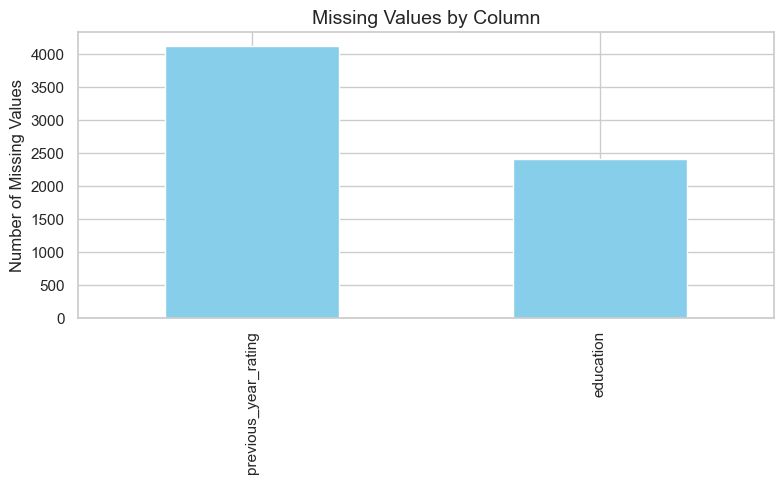


[2] Univariate Analysis


C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, order=counts.index, palette="Blues")


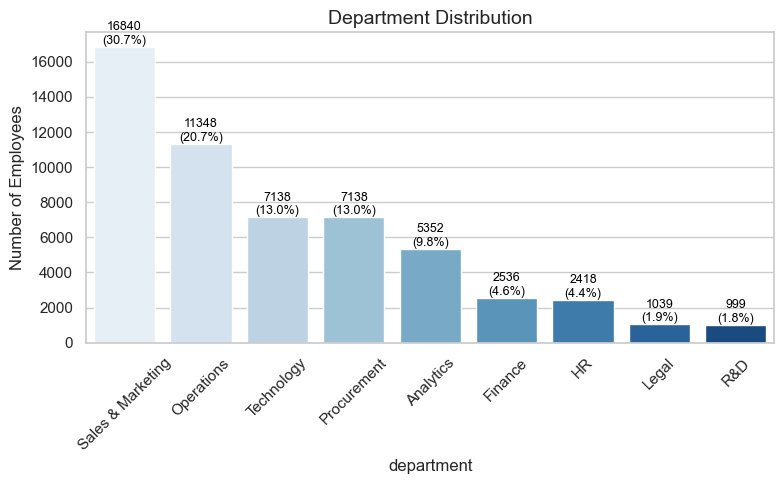

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, order=counts.index, palette="Blues")


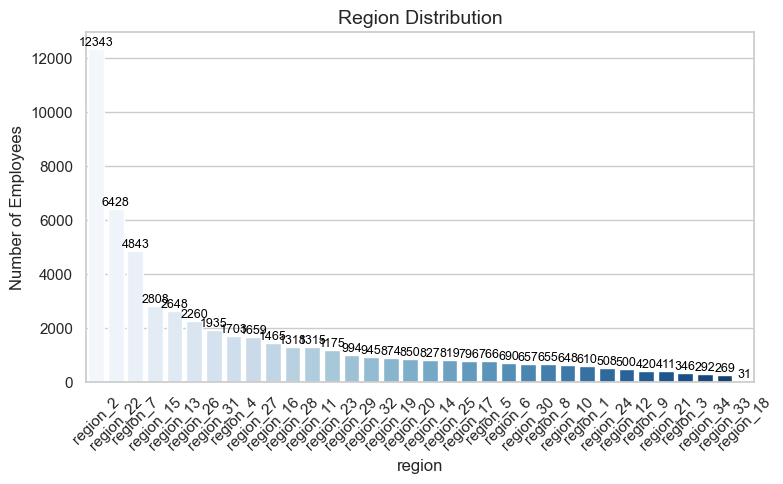

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, order=counts.index, palette="Blues")


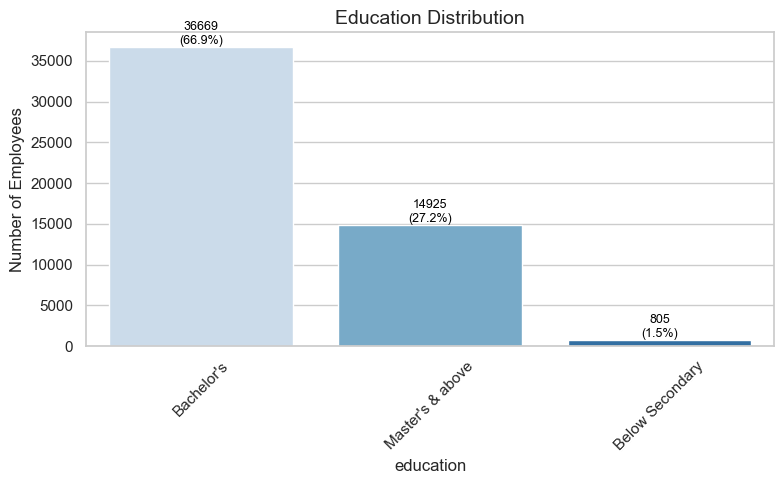

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, order=counts.index, palette="Blues")


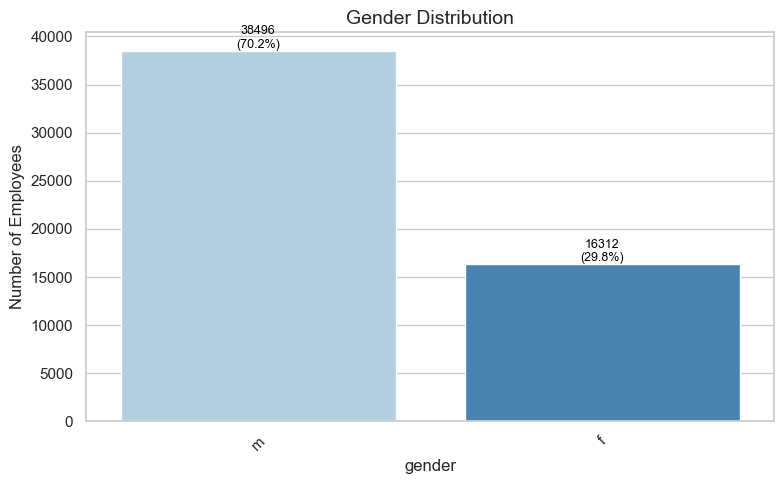

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=data, order=counts.index, palette="Blues")


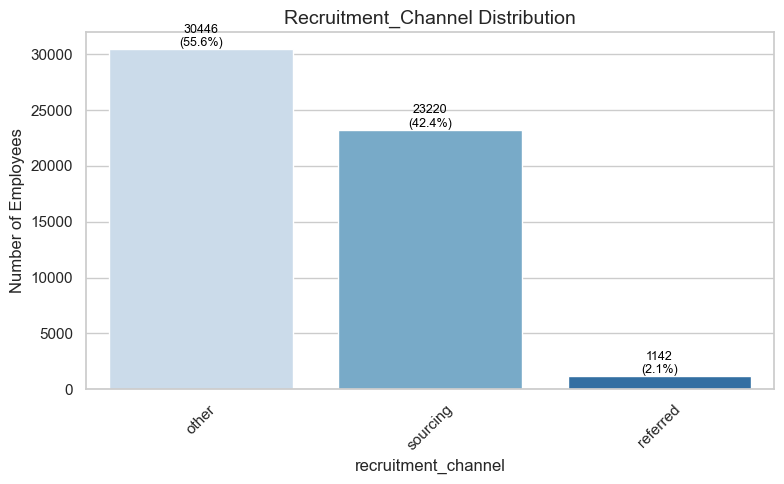

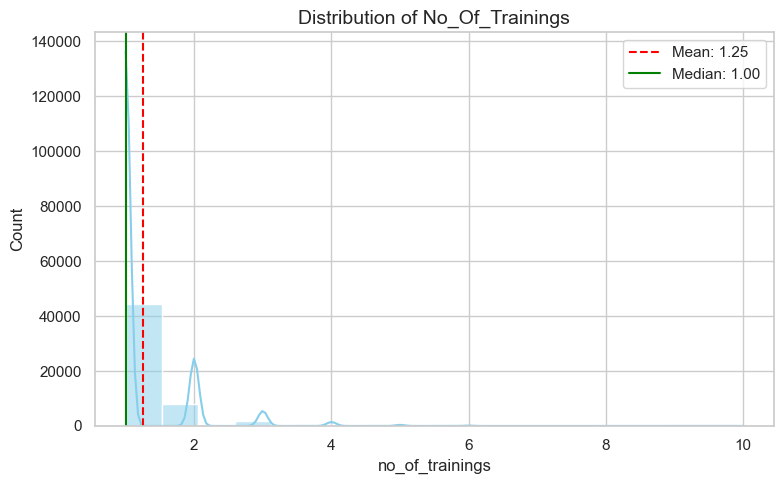

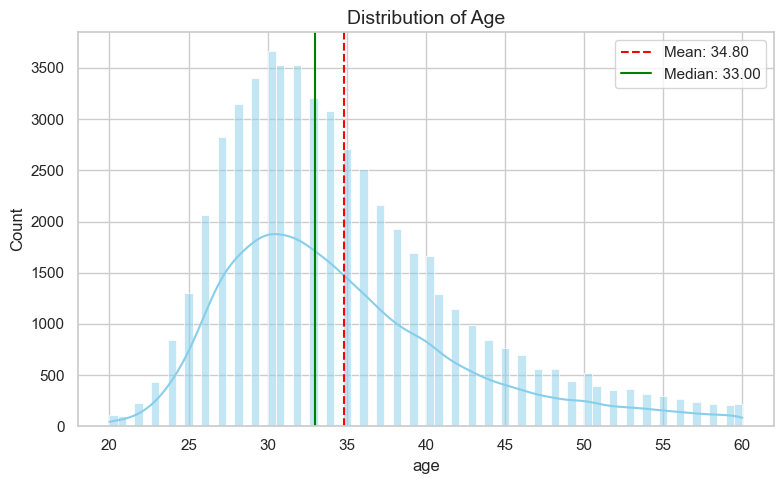

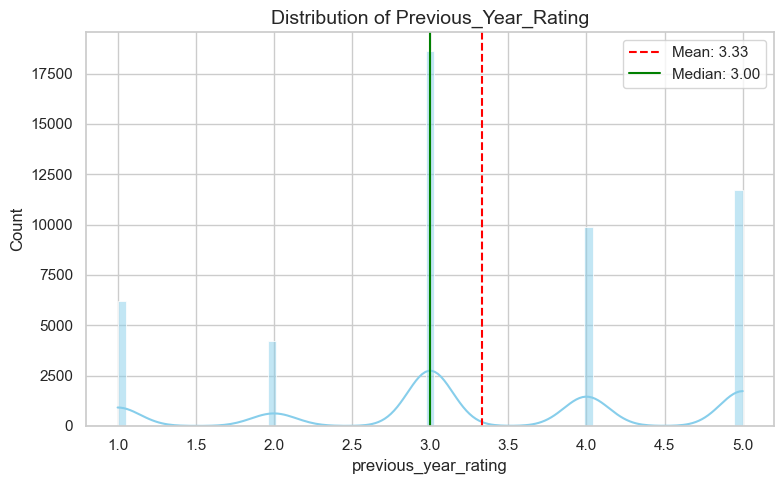

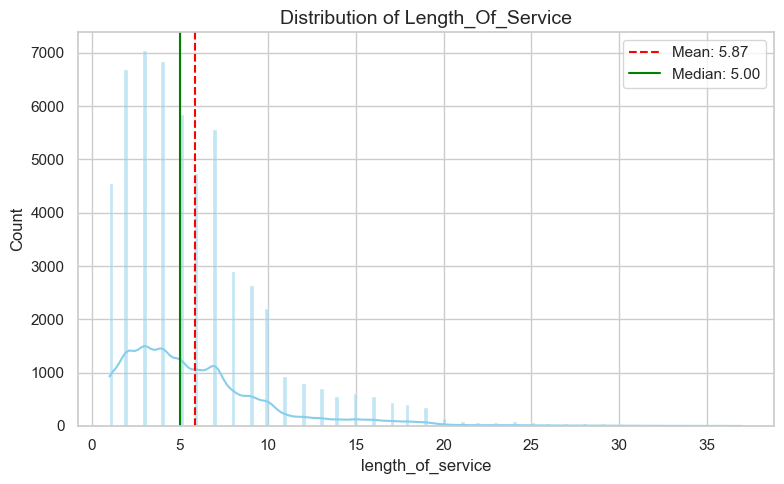

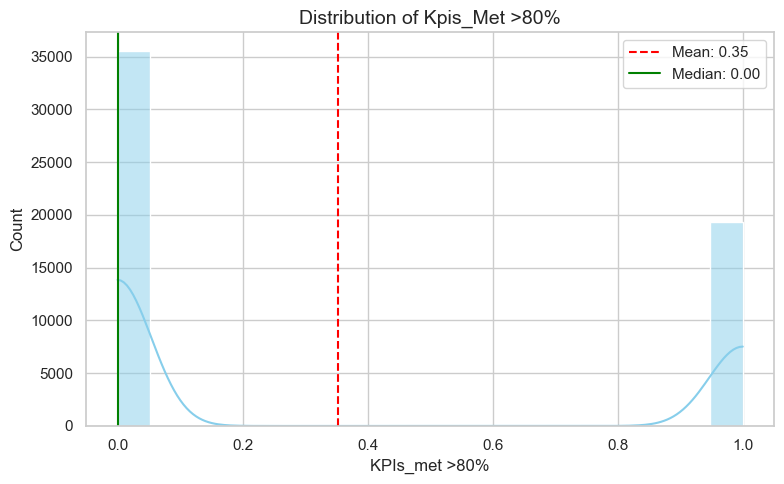

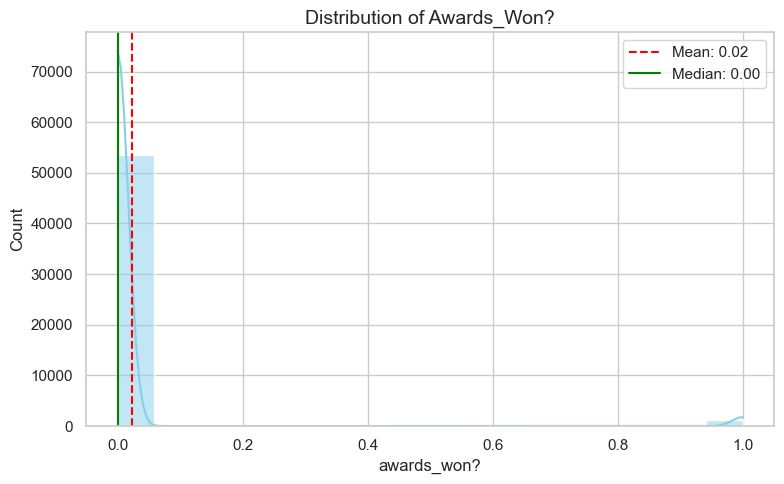

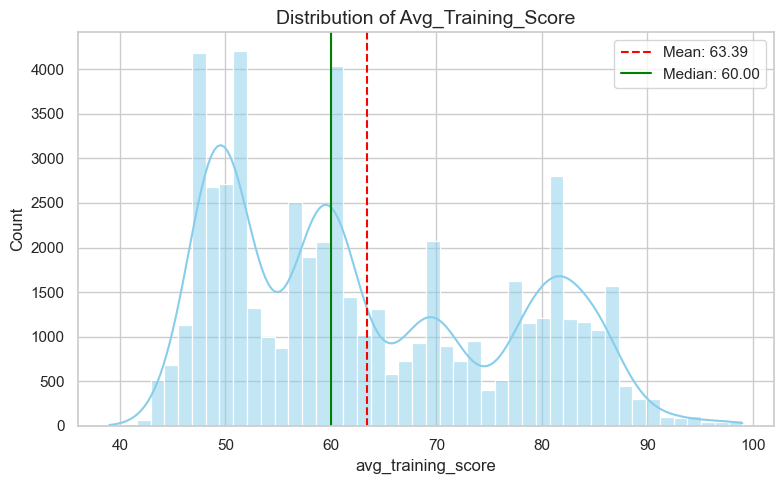


[3] Bivariate Analysis


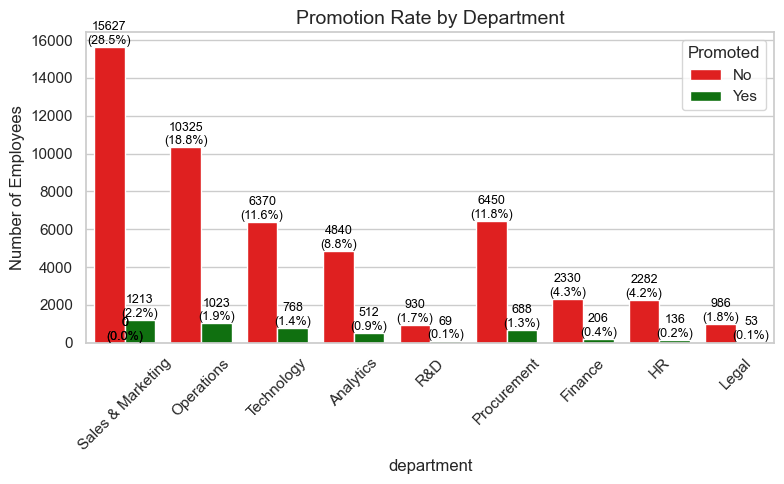

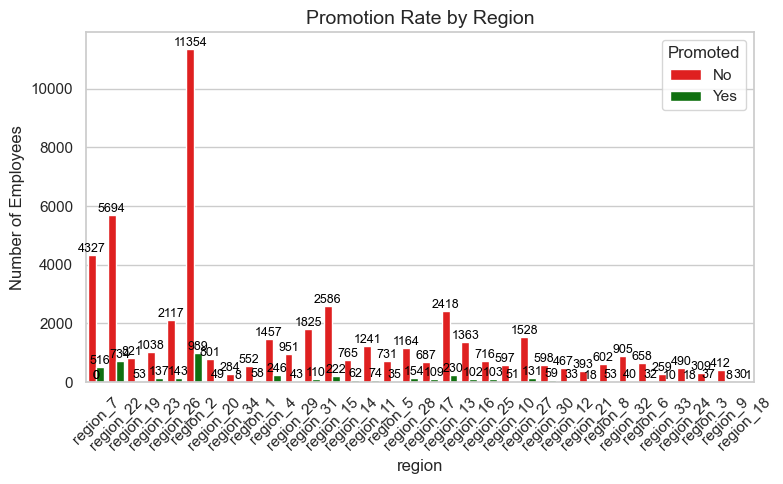

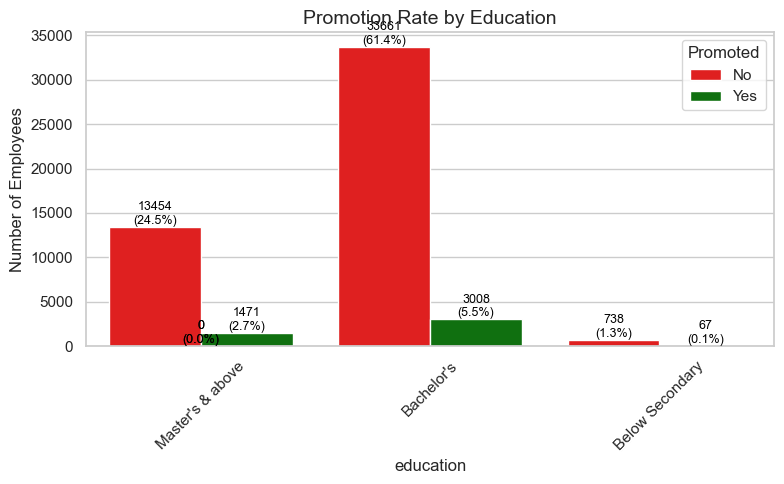

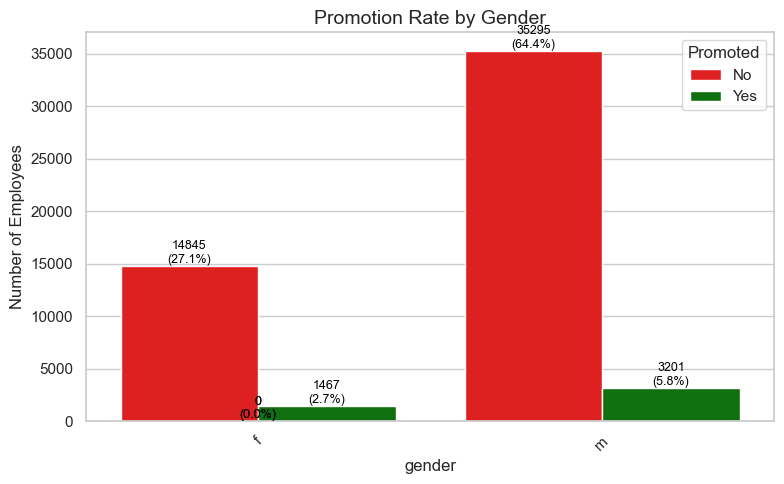

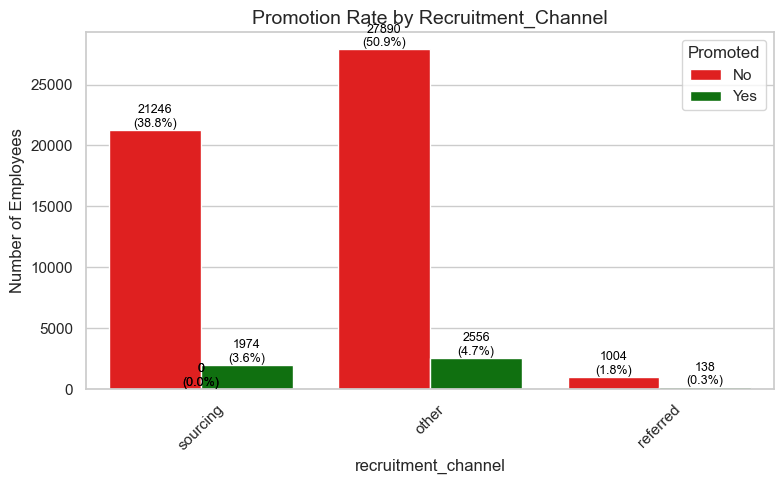

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


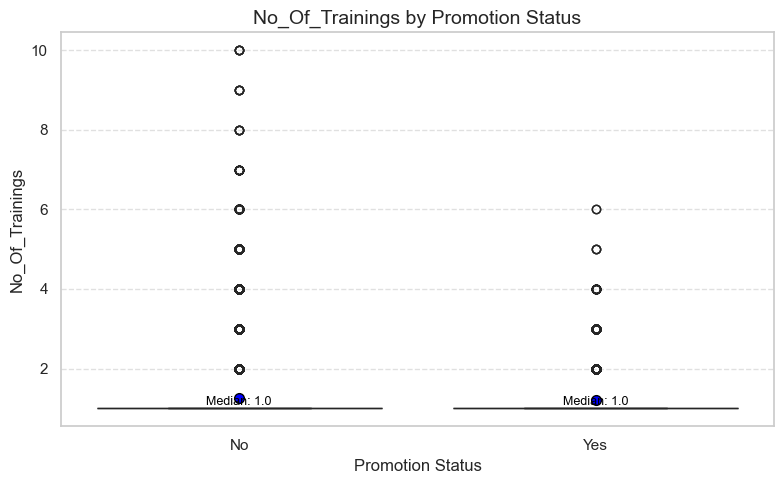

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


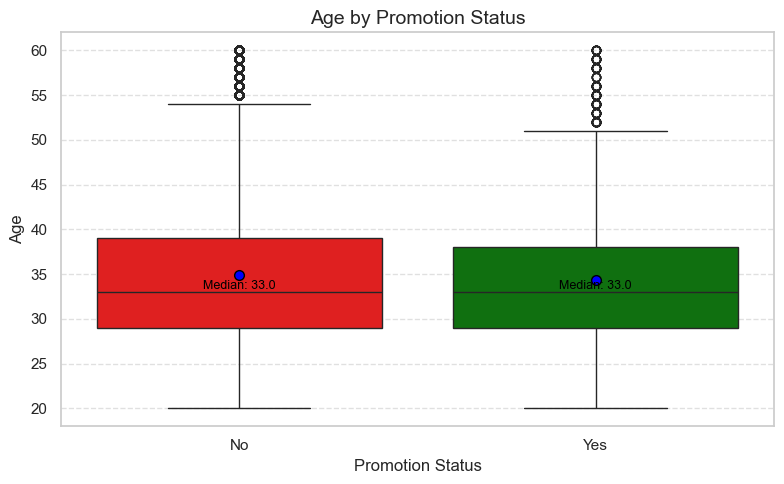

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


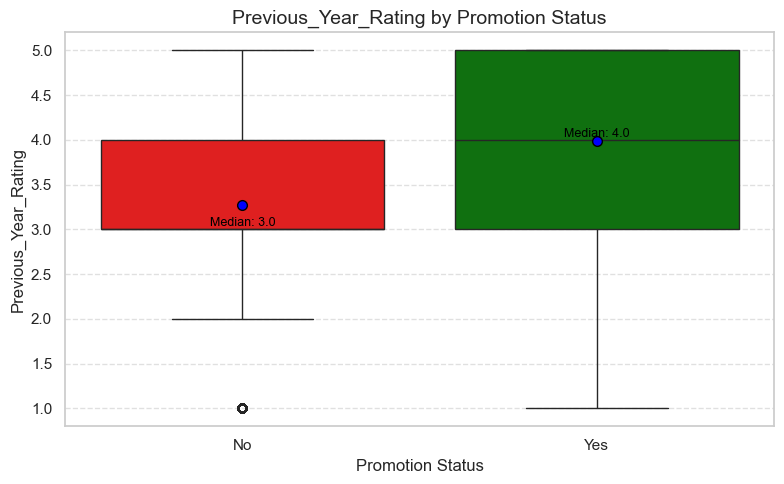

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


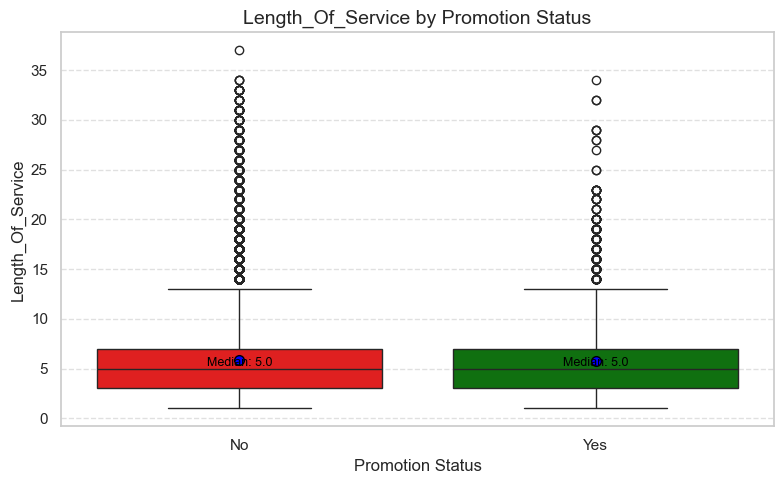

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


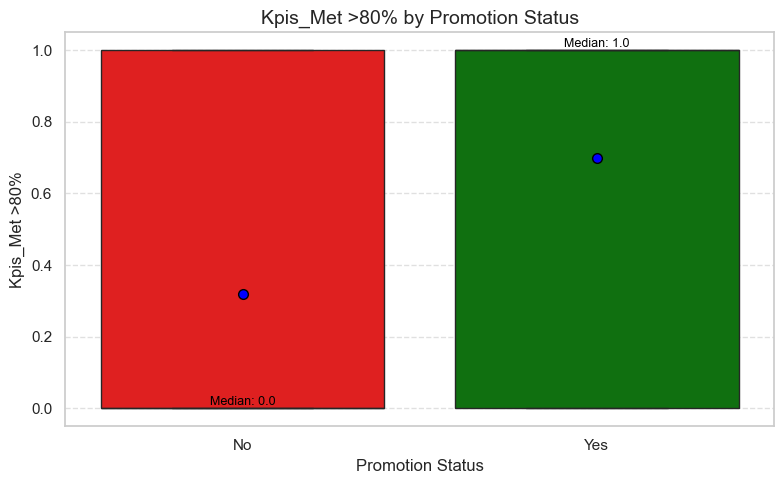

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


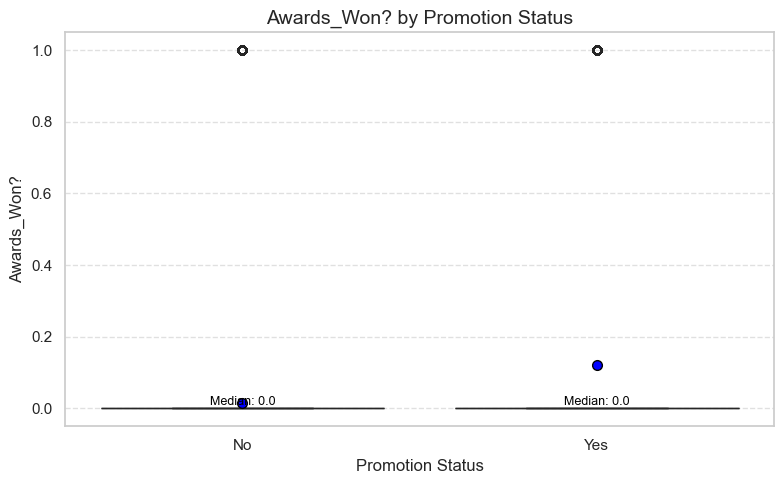

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


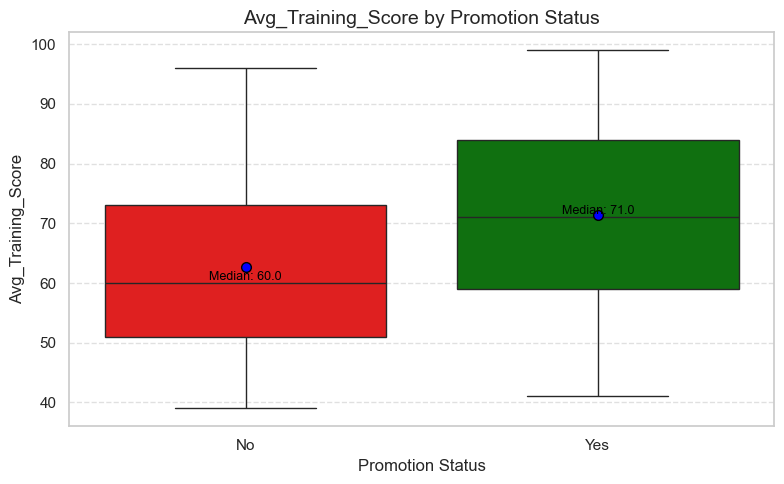

C:\Users\ayesh\Projects\HR_Analytics\notebook\../scripts\eda.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_promoted', y=col, data=data, palette=["red", "green"], showmeans=True,


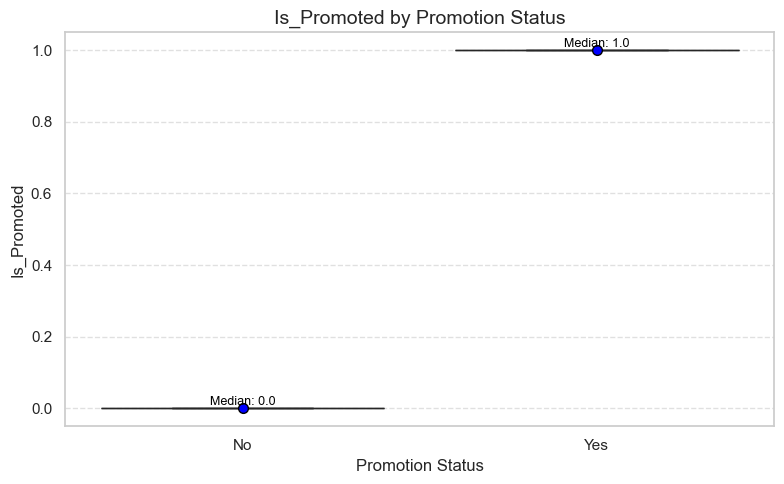


[4] Multivariate Analysis - Correlation Heatmap


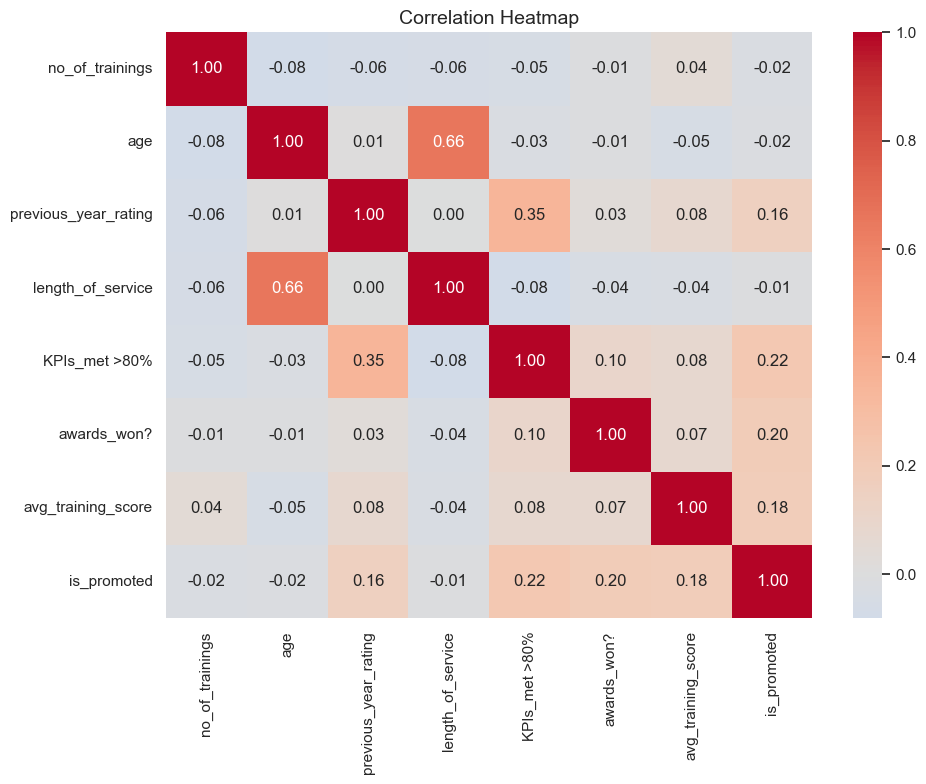


[5] Outlier Detection


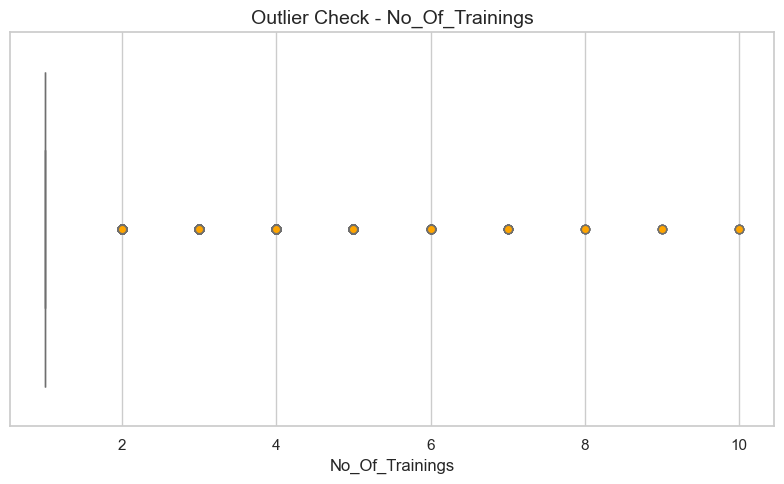

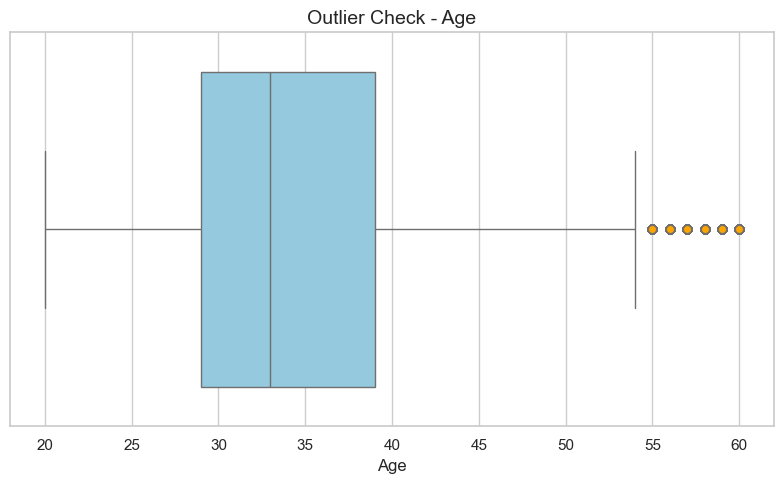

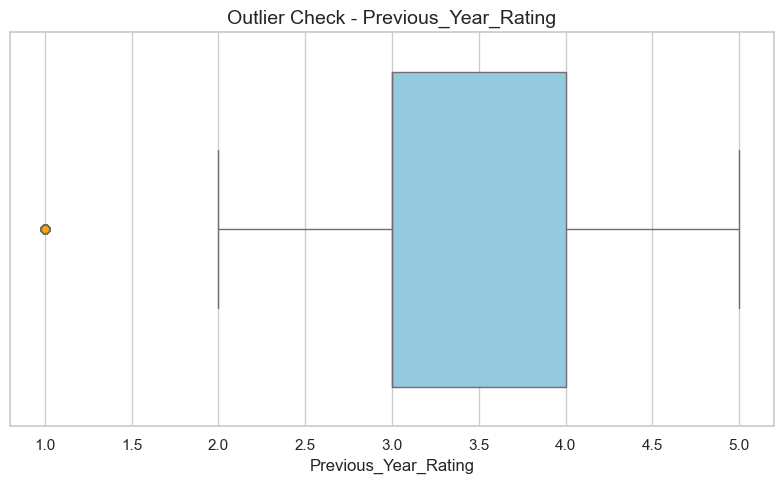

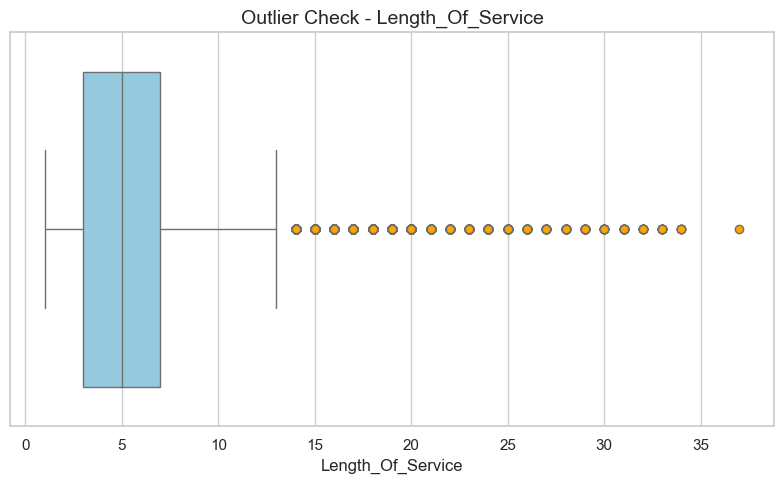

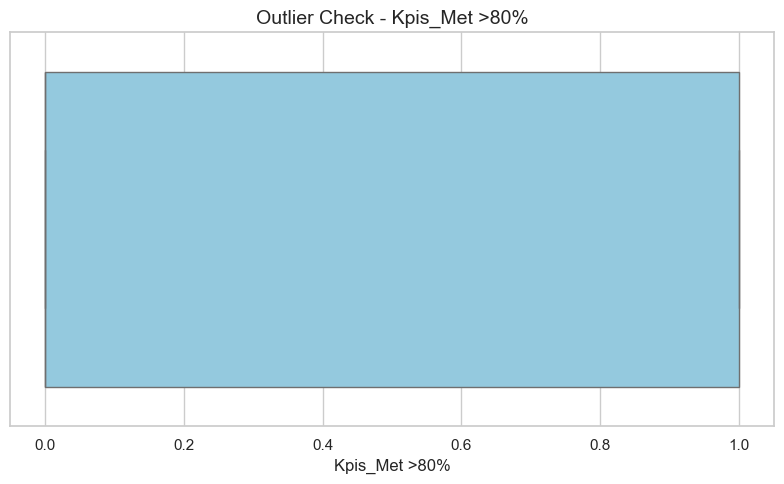

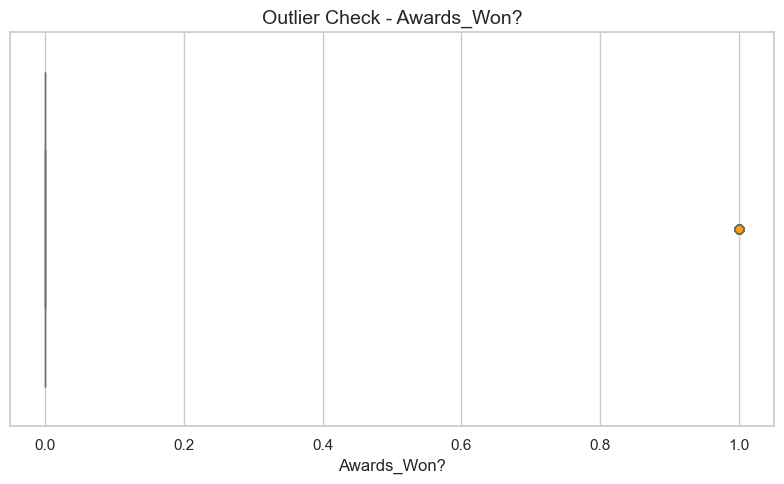

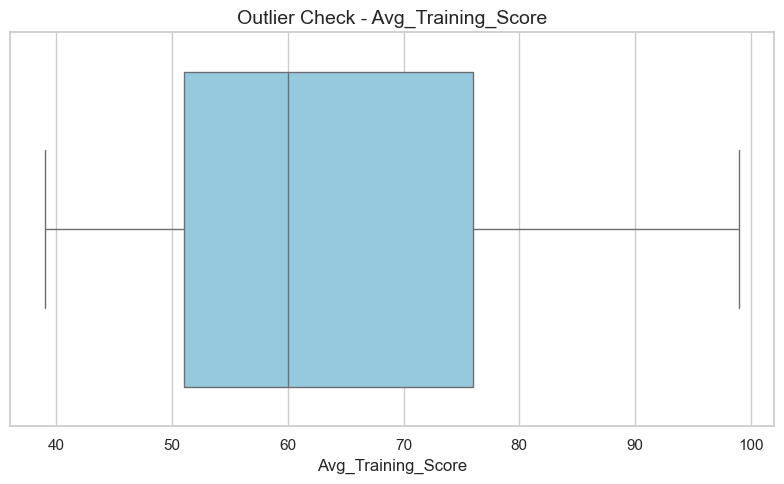

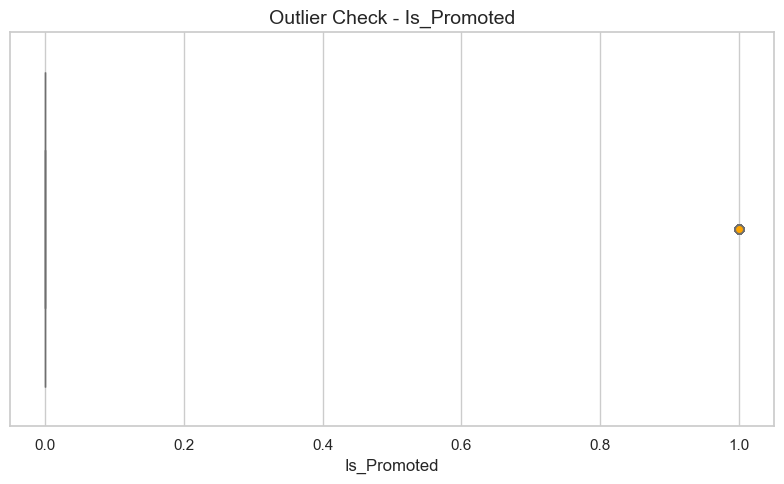

=== EDA Completed successfully.===


In [3]:
# Exploratory Data Analysis (EDA) on Train Dataset (Raw Data)
logging.info("=== Starting EDA on Train Dataset ===")
print("=== Starting EDA on Train Dataset ===")

# Step 1: Missing Values Check
check_missing_values(train_df)

# Step 2: Univariate Analysis
univariate_analysis(train_df)

# Step 3: Bivariate Analysis
bivariate_analysis(train_df)

# Step 4: Multivariate Analysis
multivariate_analysis(train_df)

# Step 5: Outlier Detection
detect_outliers(train_df)

logging.info("=== EDA Completed successfully.===")
print("=== EDA Completed successfully.===")


## Step 3: Data Preprocessing  
Before training, we need to clean and transform the raw datasets into a machine-readable format.  

**Goals:**
- Handle **missing values** in both numerical and categorical features.
- Drop `employee_id` from train only
- Encode categorical columns into numbers for ML algorithms.
- Save cleaned datasets for reuse in modeling and prediction.

We will use the `scripts/preprocessing.py` function `preprocess_and_save()` for this step.

Outputs are written to `cleaned_data/`:
- `train_processed.csv`
- `test_processed.csv`

In [4]:
# Preprocess and save datasets
train_processed, test_processed = preprocess_and_save(train_path, test_path)

logging.info("Preprocessing completed.")
print(f"Preprocessing completed.")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")

# Show first few rows of processed train dataset
print("\n--- TRAIN DATA ---")
display(train_processed.info())
display(train_processed.head())
print(train_processed.isnull().sum())

print("\n--- TEST DATA ---")
display(test_processed.info())
display(test_processed.head())
print(test_processed.isnull().sum())

# Verify cleaned files exist
os.listdir(r"C:\Users\ayesh\Projects\HR_Analytics\cleaned_data")

Preprocessing completed.
Train processed shape: (54808, 13)
Test processed shape: (23490, 13)

--- TRAIN DATA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  int32  
 1   region                54808 non-null  int32  
 2   education             54808 non-null  int32  
 3   gender                54808 non-null  int32  
 4   recruitment_channel   54808 non-null  int32  
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  54808 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%         54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: floa

None

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,7,31,2,0,2,1,35,5.0,8,1,0,49,0
1,4,14,0,1,0,1,30,5.0,4,0,0,60,0
2,7,10,0,1,2,1,34,3.0,7,0,0,50,0
3,7,15,0,1,0,2,39,1.0,10,0,0,50,0
4,8,18,0,1,0,1,45,3.0,2,0,0,73,0


department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

--- TEST DATA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  int32  
 2   region                23490 non-null  int32  
 3   education             23490 non-null  int32  
 4   gender                23490 non-null  int32  
 5   recruitment_channel   23490 non-null  int32  
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previo

None

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,8,18,0,1,2,1,24,3.0,1,1,0,77
1,74430,2,28,0,0,0,1,31,3.0,5,0,0,51
2,72255,7,4,0,1,0,1,31,1.0,4,0,0,47
3,38562,5,11,0,0,0,3,31,2.0,9,0,0,65
4,64486,1,21,0,1,2,1,30,4.0,7,0,0,61


employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64


['.ipynb_checkpoints', 'test_processed.csv', 'train_processed.csv']

## Step 4: Feature Engineering

We now create new features from the preprocessed data.  
This step helps the model capture patterns that may not be directly visible from raw columns.

**Key features to be added:**
- **Age Bucket** → Categorizing employees into `Young`, `Mid`, `Senior`.
- **Tenure Bucket** → Categorizing length of service into `New`, `Experienced`, `Veteran`.
- **High Performance Flag** → Combining KPI >80% and previous year rating >= 4.  

Saved back into the processed CSVs (in-place) with the new features added.

In [5]:
# Paths
train_processed_path = r"C:\Users\ayesh\Projects\HR_Analytics\cleaned_data\train_processed.csv"
test_processed_path = r"C:\Users\ayesh\Projects\HR_Analytics\cleaned_data\test_processed.csv"

# Apply feature engineering
train_fe, test_fe = feature_engineer_and_save(train_processed_path, test_processed_path)

print("Train shape after feature engineering:", train_fe.shape)
print("Test shape after feature engineering:", test_fe.shape)

print("\n Train feature engineering dataset:")
display(train_fe.head())
print("\n Test feature engineering dataset:")
display(test_fe.head())

Train shape after feature engineering: (54808, 16)
Test shape after feature engineering: (23490, 16)

 Train feature engineering dataset:


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,age_bucket,tenure_bucket,high_performance_flag
0,7,31,2,0,2,1,35,5.0,8,1,0,49,0,Mid,Veteran,1
1,4,14,0,1,0,1,30,5.0,4,0,0,60,0,Mid,Experienced,0
2,7,10,0,1,2,1,34,3.0,7,0,0,50,0,Mid,Veteran,0
3,7,15,0,1,0,2,39,1.0,10,0,0,50,0,Senior,Veteran,0
4,8,18,0,1,0,1,45,3.0,2,0,0,73,0,Senior,New,0



 Test feature engineering dataset:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,age_bucket,tenure_bucket,high_performance_flag
0,8724,8,18,0,1,2,1,24,3.0,1,1,0,77,Young,New,0
1,74430,2,28,0,0,0,1,31,3.0,5,0,0,51,Mid,Experienced,0
2,72255,7,4,0,1,0,1,31,1.0,4,0,0,47,Mid,Experienced,0
3,38562,5,11,0,0,0,3,31,2.0,9,0,0,65,Mid,Veteran,0
4,64486,1,21,0,1,2,1,30,4.0,7,0,0,61,Mid,Veteran,0


## Step 5. Model Training & Selection

Now that our data is cleaned and engineered with meaningful features,  
it’s time to train predictive models for employee promotions.

**Objectives:**
- Compare multiple algorithms (Logistic Regression, Decision Tree, Random Forest, XGBoost)
- Perform **cross-validation** to gauge stability
- Apply **hyperparameter tuning** for the best algorithms
- Select the best model based on test set accuracy
- Save the model for deployment

**Review Results:**
- The model above will be saved in the `output/models/` folder  
as a `.pkl` file for future predictions in the app or prediction script.

In [6]:
# Train, Evaluate & Save Best Model
best_model_name, best_model_score, best_model = train_and_save_model(train_processed_path)

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_model_score:.4f}")


 Cross-Validation Results:
Logistic Regression: 0.9176 (+/- 0.0008)
Decision Tree: 0.8948 (+/- 0.0029)
Random Forest: 0.9290 (+/- 0.0011)
XGBoost: 0.9404 (+/- 0.0015)

 Hyperparameter Tuning...
Best RF Params: {'max_depth': None, 'n_estimators': 100}
Best XGB Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

 Final Test Set Evaluation:

RandomForest_Tuned - Accuracy: 0.9298
classification_report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     10028
           1       0.79      0.24      0.37       934

    accuracy                           0.93     10962
   macro avg       0.86      0.62      0.67     10962
weighted avg       0.92      0.93      0.91     10962

Confusion Matrix:
 [[9968   60]
 [ 710  224]]

XGBoost_Tuned - Accuracy: 0.9431
classification_report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     10028
           1       0.95      0.35      

## Step 7: Predictions on Test Set
We will now use the **best saved model** to make predictions on the **preprocessed test dataset** and save the results.

We will use the `predict_and_save` function from our `scripts/predict.py` to generate predictions and save them for review.

**Steps:**
1. Load the saved `.pkl` model
2. Load preprocessed test dataset
3. Apply necessary encodings
4. Predict `is_promoted`
5. Save predictions to `/output/predictions/`
   
We now score the **test** dataset and save predictions as:  
`output/predictions/predictions.csv` with columns:  
- `employee_id`  
- `is_promoted_predicted` (0/1)

Note: We ensure any **object** buckets are cast to numeric codes so XGBoost/Sklearn can consume them.

In [7]:
# Paths
model_file = "../output/models/XGBoost_Tuned.pkl"
test_file = "../cleaned_data/test_processed.csv"
output_file = "../output/predictions/predictions.csv"

# Predictions on Test Set
predict_and_save(
    model_path=model_file,
    test_path=test_file,
    output_path=output_file
)

print("\n The first 10 predictions from predictions.csv file:")
pd.read_csv(output_file).head(10)



 First 10 Predictions:
   employee_id  is_promoted_predicted
0         8724                      0
1        74430                      0
2        72255                      0
3        38562                      0
4        64486                      0
5        46232                      0
6        54542                      0
7        67269                      0
8        66174                      0
9        76303                      0

 Predictions saved to ../output/predictions/predictions.csv

 The first 10 predictions from predictions.csv file:


,employee_id,is_promoted_predicted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
5,46232,0
6,54542,0
7,67269,0
8,66174,0
9,76303,0


## Step 8: Insights & Recommendations

We can now hand over these results to HR for review and further decision-making.

### 1. Model Performance Recap
- **Best Model:** XGBoost_Tuned  
- **Test Accuracy:** 0.9431  
- **Precision, Recall, F1-Score:**  
  - Class 0 (Not Promoted): Precision 0.94, Recall 1.00, F1 0.97  
  - Class 1 (Promoted): Precision 0.95, Recall 0.35, F1 0.51  
- **Confusion Matrix:**
    Confusion Matrix:
    [[10012    16]
    [  608   326]]
- The model performs well overall, but recall for promoted employees is lower due to class imbalance.  

---

### 2. Key Insights
- **Top drivers of promotion:**  
1. Higher `previous_year_rating`  
2. KPIs_met > 80%  
3. `avg_training_score`  
4. Awards (`awards_won?`)  
5. Balanced tenure (not too short, not excessively long)  
- **Tenure effects** are non-linear: mid-range tenure often fares better than very short or long tenure.  
- High training scores and KPI alignment consistently predict promotion likelihood.  

---

### 3. Recommendations for HR
1. **Invest in KPI alignment and training programs** — support employees close to >80% KPI threshold.  
2. **Transparent performance feedback** — ensure prior-year ratings are timely and fairly calibrated.  
3. **Targeted development programs** — mid-tenure employees are often “promotion-ready.”  
4. **Audit fairness** — periodically check promotion decisions across departments, regions, and demographics.  
5. **Monitor model predictions** — consider human-in-the-loop for edge cases.  

---

### 4. Future Enhancements
- **Probability threshold calibration** — adjust for desired Recall vs Precision based on HR risk preference.  
- **SHAP or explainable ML** — deeper interpretability at the individual employee level.  
- **Bias and fairness audits** — ensure equitable decisions across demographic groups.  
- **Monitor model drift** — schedule periodic retraining to maintain performance.  
- **Cost-sensitive evaluation** — consider false negative vs false positive costs in HR workflow.  

---

### 5. Next Steps 
- **Calibrate thresholds** for Recall vs Precision based on HR's risk preference.
- **Add cost-sensitive evaluation** (false negative vs false positive costs). 
- **Add probability calibration** to enable threshold-based HR workflows.
- **Bias and fairness audits** — monitor model across demographic groups.
- **Use SHAP values** for individual-level explanations.
- **Monitor drift & retrain** periodically.
  
---

**These findings can now be shared with HR leadership for review and potential integration into promotion decision workflows.**

---

**Thank you for reviewing this analysis. These insights can be leveraged to make data-driven promotion decisions while maintaining fairness and transparency.**
